<a href="https://colab.research.google.com/github/Barryjuait/Barryjuait/blob/master/Personal%20Projects/COVIDadverse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Task: Exploring Covid-19 and non-Covid vaccine reports VAERS 2020

For the second interview, we would like to ask you to analyse a dataset containing reports of suspected side-effects with free-text information.
During investigations of safety concerns with medicinal products, pharmacovigilance experts will evaluate the causality between the medicinal product and the observed side effect. For this, they need as much information as possible to understand each report and what happened to that patient in as much detail as possible. They do not usually have the possibility to reach the patient and ask follow up questions. They therefore rely not only on structured information but also on the narrative descriptions of the side effect if available. These can include information about the course of events, the symptoms, the severity and quality of life of the patient but also information about concomitant factors such as other drugs or other differential diagnosis. Reports of suspected side effects can be sent by different reporters, for example the patient themselves, health care professionals or pharmaceutical companies.

For this assignment, we would like you to look at reports from VAERS in 2020, the US database for adverse events reported for vaccines. You can download it
here: https://vaers.hhs.gov/data/datasets.html. **Use the CSV files VAERS DATA and VAERS VACCINE** (both files contain a unique ID VAERS_ID for linking the tables). The narrative field is in the VAERS DATA file in column SYMPTOM_TEXT but there exist other free-text fields on the reports. The vaccine information can be found in the VAERS VACCINE/VAX file the column VAX_NAME contains the vaccine name for the report and you can identify the COVID19 reports using this column. Since the data is from the US in 2020, it includes reports for Covid-19 vaccines and other vaccines. The question that we would like you to answer is:

 **Are COVID-19 vaccine narratives different from narratives for other vaccines??**

Some suggestions for questions that you may want to answer during your exploration are:

* Are more or less narratives written in the first person?
* Is there more redundancy in covid-19 vaccine narratives?


Explanation of the dataset: https://vaers.hhs.gov/docs/VAERSDataUseGuide_November2020.pdf


In [1]:
import os
import glob
import pandas as pd
import numpy as np
import re
import cv2
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from itertools import groupby
from operator import itemgetter
from sklearn.metrics import silhouette_score, confusion_matrix, f1_score, classification_report, accuracy_score
from scipy.stats import kruskal, f_oneway
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, scale
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors, metrics)
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.feature_selection import (f_classif, VarianceThreshold, chi2, mutual_info_classif, SelectKBest,
                                       SelectPercentile, SelectFromModel)
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, Lasso

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


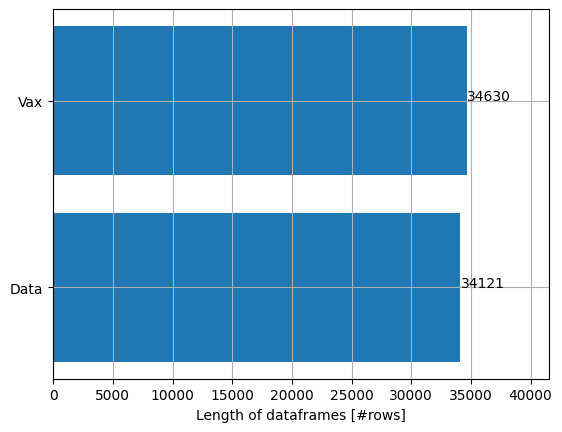

In [3]:
#open and load files:
analysisFolder = '/content/drive/MyDrive/Colab Notebooks/Pharmacovigilance/Covid_adverseRx/archive/'
picFolder = analysisFolder + 'Figs'

df_data = pd.read_csv(analysisFolder + '2021VAERSDATA.csv', delimiter=',', encoding='latin-1')
#df_symp = pd.read_csv(analysisFolder + '2021VAERSSYMPTOMS.csv', delimiter=',', encoding='latin-1')
df_vax = pd.read_csv(analysisFolder + '2021VAERSVAX.csv', delimiter=',', encoding='latin-1')


x = ['Data', 'Vax']
y = [len(df_data), len(df_vax)];
plt.barh(x, y)
for i in range(len(x)):
    plt.text(y[i], i, y[i], ha = 'left')
plt.xlabel('Length of dataframes [#rows]')
plt.xlim([0, np.max(y)*1.2])
plt.grid()
plt.show()



since the data from both dataframes are not the same length, we will need to explore it to find the best way to merge them.

we group by patient ID:

In [4]:
# Merge df_data with df_symp using 'VAERS_ID' as the key
dff = df_data.merge(df_vax, on='VAERS_ID', how='inner')

# Drop duplicate rows based on 'VAERS_ID'
dff.drop_duplicates(subset='VAERS_ID', keep='first', inplace=True)

# Reset the index
dff.reset_index(drop=True, inplace=True)

dff.describe().T

,count,mean,std,min,25%,50%,75%,max
VAERS_ID,34121.0,981306.591190,62045.354319,916600.00,926464.0,946837.0,1047069.0,1115348.0
AGE_YRS,30933.0,51.471923,18.521742,0.08,37.0,50.0,65.0,115.0
CAGE_YR,26791.0,51.135381,18.633316,0.00,36.0,49.0,65.0,106.0
CAGE_MO,83.0,0.084337,0.178395,0.00,0.0,0.0,0.0,0.7
HOSPDAYS,2857.0,3.752888,3.878654,1.00,1.0,3.0,5.0,39.0
NUMDAYS,31194.0,21.077066,644.834400,0.00,0.0,1.0,3.0,36896.0
FORM_VERS,34121.0,1.998124,0.043269,1.00,2.0,2.0,2.0,2.0


## Descriptive Analysis

In [5]:
print(f'This is an example of the symptoms reported: \n\n{dff.SYMPTOM_TEXT[0]}')

This is an example of the symptoms reported: 

Right side of epiglottis swelled up and hinder swallowing pictures taken Benadryl Tylenol taken


In [6]:
#These are some of the most common words found in the database indicating the non-existing values:
NegL = ['NaN', 'nan', 'None', 'none', 'no known', 'Known Known', 'UKN', 'None noted', 'NA', 'Not known', 'No known allergies.', 'No known allergies', 'not known', 'notknown', 'NKA', 'NKDA', 'No', 'NO', 'none listed', 'none lister', 'NONE', 'none reported']

In [7]:
#Let's fix some of the booleans in the dataframe:
bBool = ['RECOVD', 'DIED']

for var in bBool:
  dff[var][np.in1d(dff[var], NegL)] = 'N'


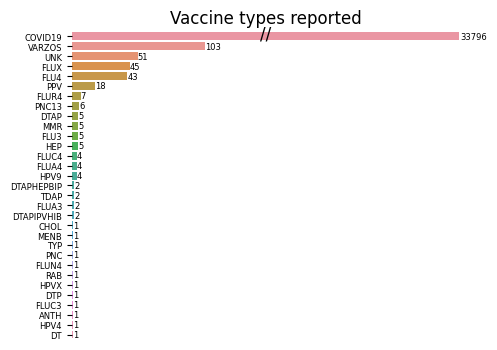

In [8]:
fig, ax = plt.subplots(1,1, figsize = (5,4), sharey = False)
hax = ax;
sns.countplot(ax = hax, data = dff, y = 'VAX_TYPE', order = dff.VAX_TYPE.value_counts().index);
hax.set(frame_on=False, xticks=[], xlabel = None, ylabel = None, xlim = [0, 300]);
a = hax.bar_label(hax.containers[0], fontsize = 6);
hax.set_yticklabels(labels = dff.VAX_TYPE.value_counts().index, fontsize = 6)
hax.text(301, 0.25, np.sum(dff.VAX_TYPE == 'COVID19'), ha = 'left', fontsize = 6);
hax.text(150, 0.25, '//', ha = 'center', fontsize = 12);
hax.set_title('Vaccine types reported')

plt.show()

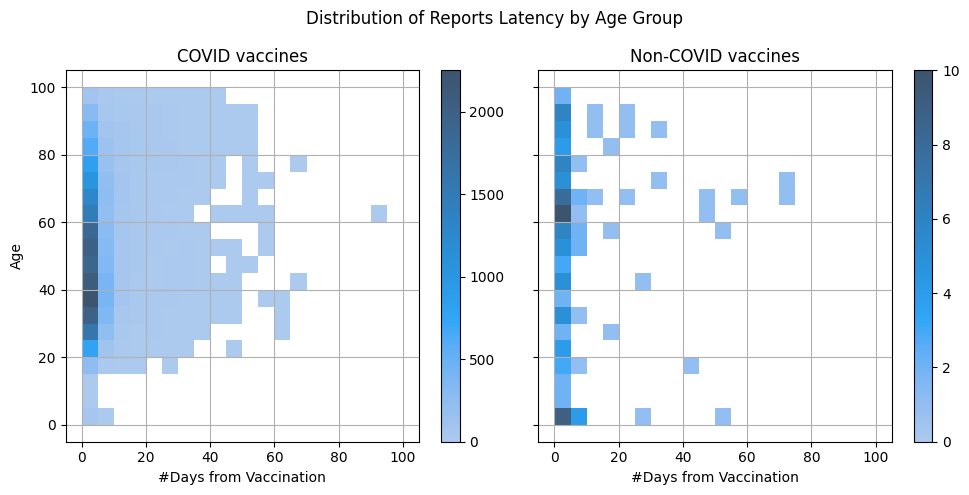

In [9]:
fig, ax = plt.subplots(1,2, figsize = (10,5), sharey = True)
bins = [*range(0,101,5)]
hax = ax[0]
sns.histplot(ax = hax, data = dff[dff.VAX_TYPE == 'COVID19'], y = 'CAGE_YR', x = 'NUMDAYS', bins = bins, cbar = True);
hax.set(frame_on=True, xlabel = '#Days from Vaccination', ylabel = 'Age')
hax.set_title('COVID vaccines')
hax.grid()

hax = ax[1]
sns.histplot(ax = hax, data = dff[dff.VAX_TYPE != 'COVID19'], y = 'CAGE_YR', x = 'NUMDAYS', bins = bins, cbar = True);
hax.set(frame_on=True, xlabel = '#Days from Vaccination', ylabel = 'Age')
hax.set_title('Non-COVID vaccines')
hax.grid()

plt.suptitle('Distribution of Reports Latency by Age Group')
plt.tight_layout();

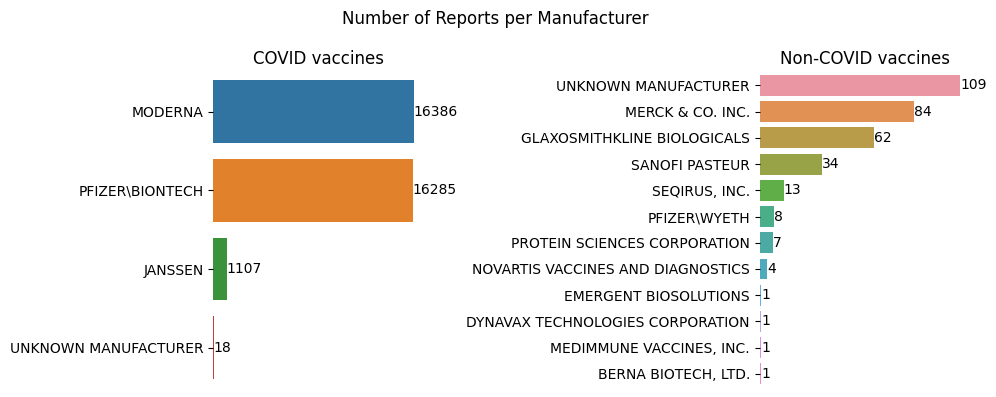

In [10]:
var = 'VAX_MANU'

fig, ax = plt.subplots(1,2, figsize = (10,4), sharey = False)
sel = (dff.VAX_TYPE == 'COVID19')
hax = ax[0]
sns.countplot(ax = hax, data = dff[sel], y = var, order = dff[var][sel].value_counts().index)
hax.set(frame_on=False, xticks=[], xlabel = None, ylabel = None)
hax.bar_label(hax.containers[0]);
hax.set_title('COVID vaccines')

sel = (dff.VAX_TYPE != 'COVID19')
hax = ax[1]
sns.countplot(ax = hax, data = dff[sel], y = var, order = dff[var][sel].value_counts().index)
hax.set(frame_on=False, xticks=[], xlabel = None, ylabel = None)
hax.bar_label(hax.containers[0]);
hax.set_title('Non-COVID vaccines')

plt.suptitle('Number of Reports per Manufacturer')
plt.tight_layout()

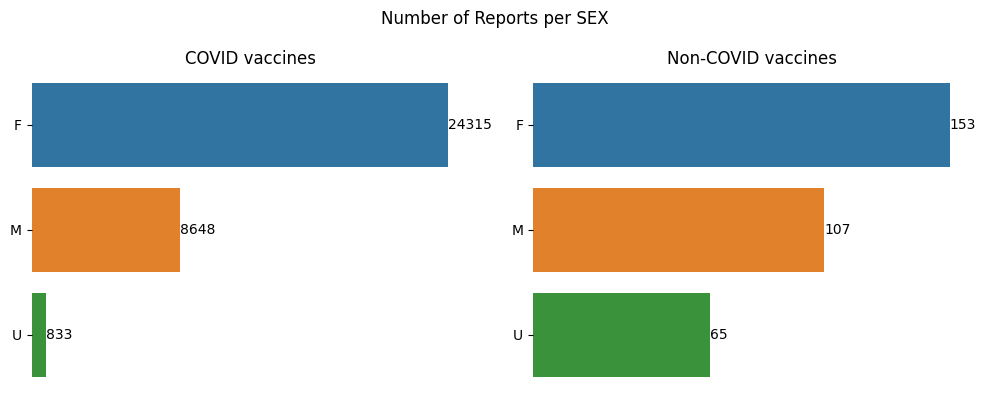

In [11]:
var = 'SEX'

fig, ax = plt.subplots(1,2, figsize = (10,4), sharey = False)
sel = (dff.VAX_TYPE == 'COVID19')
hax = ax[0]
sns.countplot(ax = hax, data = dff[sel], y = var, order = dff[var][sel].value_counts().index)
hax.set(frame_on=False, xticks=[], xlabel = None, ylabel = None)
hax.bar_label(hax.containers[0]);
hax.set_title('COVID vaccines')

sel = (dff.VAX_TYPE != 'COVID19')
hax = ax[1]
sns.countplot(ax = hax, data = dff[sel], y = var, order = dff[var][sel].value_counts().index)
hax.set(frame_on=False, xticks=[], xlabel = None, ylabel = None)
hax.bar_label(hax.containers[0]);
hax.set_title('Non-COVID vaccines')

plt.suptitle('Number of Reports per SEX')
plt.tight_layout()

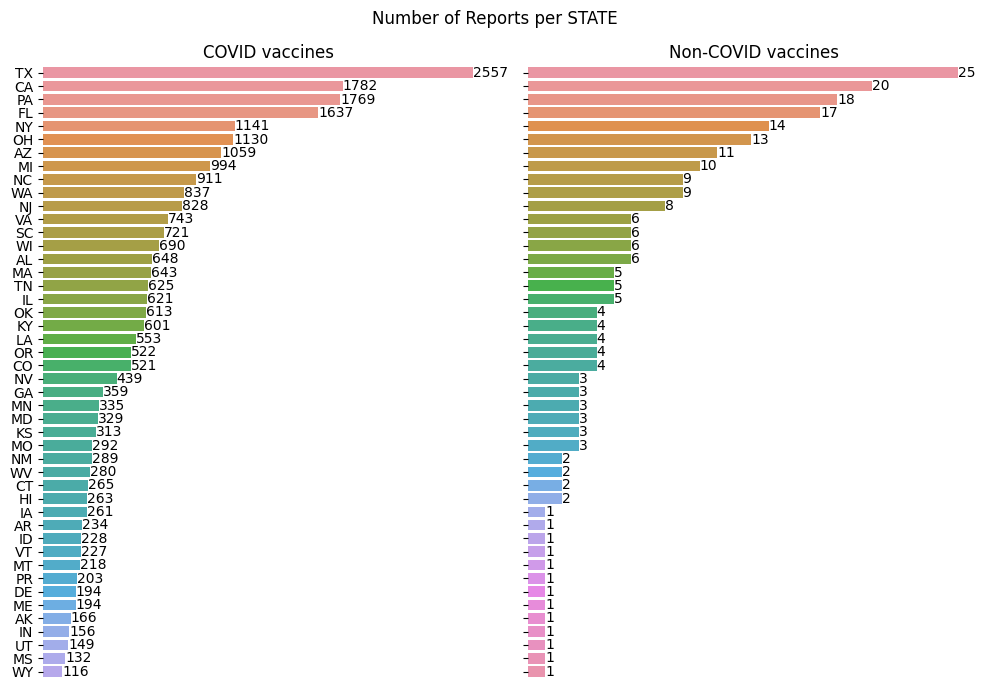

In [12]:
var = 'STATE'

fig, ax = plt.subplots(1,2, figsize = (10,7), sharey = True)
sel = (dff.VAX_TYPE == 'COVID19')
hax = ax[0]
sns.countplot(ax = hax, data = dff[sel], y = var, order = dff[var][sel].value_counts().index)
hax.set(frame_on=False, xticks=[], xlabel = None, ylabel = None)
hax.bar_label(hax.containers[0]);
hax.set_title('COVID vaccines')

sel = (dff.VAX_TYPE != 'COVID19')
hax = ax[1]
sns.countplot(ax = hax, data = dff[sel], y = var, order = dff[var][sel].value_counts().index)
hax.set(frame_on=False, xticks=[], xlabel = None, ylabel = None)
hax.bar_label(hax.containers[0]);
hax.set_title('Non-COVID vaccines')

plt.suptitle('Number of Reports per STATE')
plt.tight_layout()

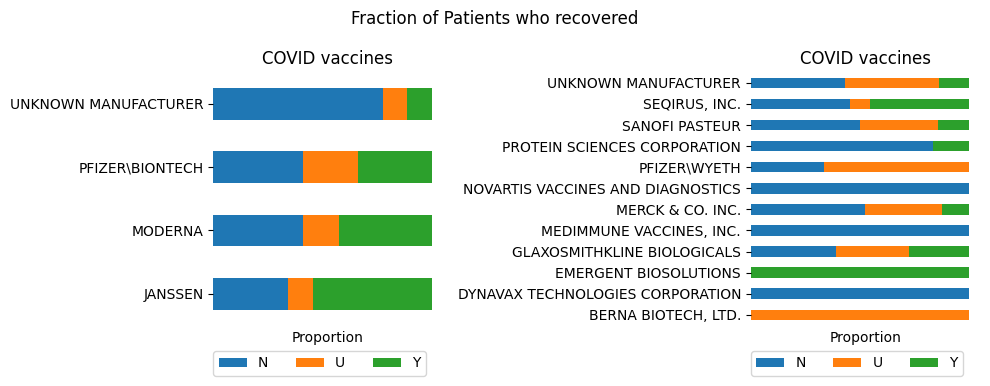

In [13]:
sel = dff.VAX_TYPE == 'COVID19'

fig, ax = plt.subplots(1,2, figsize = (10,4))
hax = ax[0]
tabProp = pd.crosstab(index = dff[sel]['VAX_MANU'], columns = dff[sel]['RECOVD'], normalize = "index")
tabProp.plot(kind='barh', stacked=True, ax = hax)
hax.legend(loc=(0, -0.2), ncol=3)
hax.set(frame_on=False, xticks=[], xlabel = 'Proportion', ylabel = None,
        title = 'COVID vaccines')

hax = ax[1]
tabProp = pd.crosstab(index = dff[~sel]['VAX_MANU'], columns = dff[~sel]['RECOVD'], normalize = "index")
tabProp.plot(kind='barh', stacked=True, ax = hax)
hax.legend(loc=(0, -0.2), ncol=3)
hax.set(frame_on=False, xticks=[], xlabel = 'Proportion', ylabel = None,
        title = 'COVID vaccines')
plt.suptitle('Fraction of Patients who recovered')
plt.tight_layout()

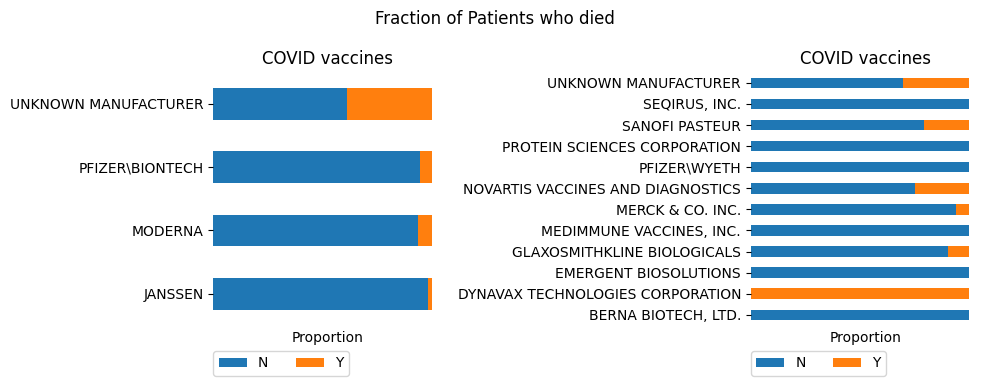

In [14]:
sel = dff.VAX_TYPE == 'COVID19'

dummy = dff.copy()
dummy.DIED[dummy.DIED != 'Y'] = 'N'
fig, ax = plt.subplots(1,2, figsize = (10,4))
hax = ax[0]
tabProp = pd.crosstab(index = dummy[sel]['VAX_MANU'], columns = dummy[sel]['DIED'], normalize = "index")
tabProp.plot(kind='barh', stacked=True, ax = hax)
hax.legend(loc=(0, -0.2), ncol=3)
hax.set(frame_on=False, xticks=[], xlabel = 'Proportion', ylabel = None,
        title = 'COVID vaccines')

hax = ax[1]
tabProp = pd.crosstab(index = dummy[~sel]['VAX_MANU'], columns = dummy[~sel]['DIED'], normalize = "index")
tabProp.plot(kind='barh', stacked=True, ax = hax)
hax.legend(loc=(0, -0.2), ncol=3)
hax.set(frame_on=False, xticks=[], xlabel = 'Proportion', ylabel = None,
        title = 'COVID vaccines')
plt.suptitle('Fraction of Patients who died')
plt.tight_layout()

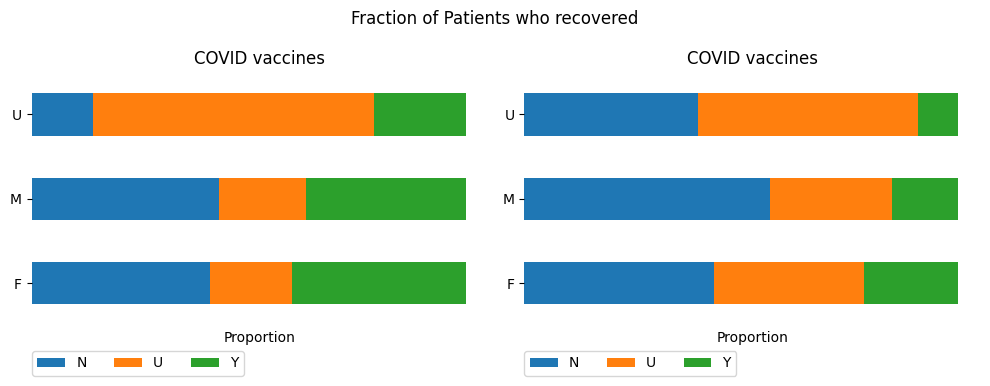

In [15]:
sel = dff.VAX_TYPE == 'COVID19'

fig, ax = plt.subplots(1,2, figsize = (10,4))
hax = ax[0]
tabProp = pd.crosstab(index = dff[sel]['SEX'], columns = dff[sel]['RECOVD'], normalize = "index")
tabProp.plot(kind='barh', stacked=True, ax = hax)
hax.legend(loc=(0, -0.2), ncol=3)
hax.set(frame_on=False, xticks=[], xlabel = 'Proportion', ylabel = None,
        title = 'COVID vaccines')

hax = ax[1]
tabProp = pd.crosstab(index = dff[~sel]['SEX'], columns = dff[~sel]['RECOVD'], normalize = "index")
tabProp.plot(kind='barh', stacked=True, ax = hax)
hax.legend(loc=(0, -0.2), ncol=3)
hax.set(frame_on=False, xticks=[], xlabel = 'Proportion', ylabel = None,
        title = 'COVID vaccines')
plt.suptitle('Fraction of Patients who recovered')
plt.tight_layout()

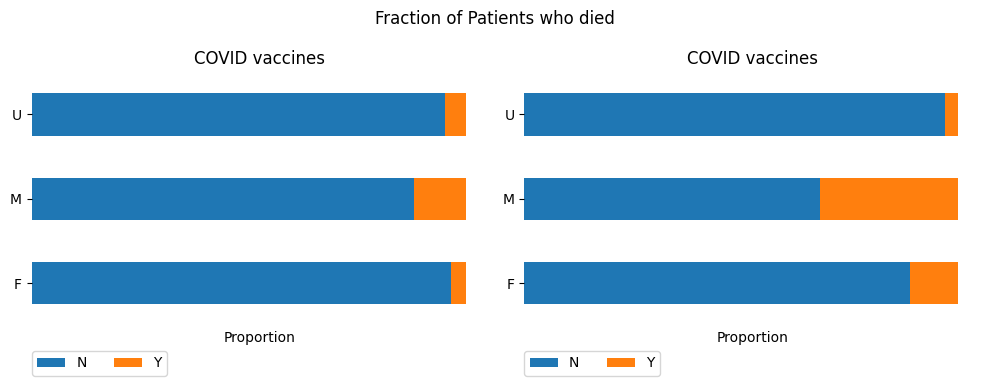

In [16]:
sel = dff.VAX_TYPE == 'COVID19'

dummy = dff.copy()
dummy.DIED[dummy.DIED != 'Y'] = 'N'
fig, ax = plt.subplots(1,2, figsize = (10,4))
hax = ax[0]
tabProp = pd.crosstab(index = dummy[sel]['SEX'], columns = dummy[sel]['DIED'], normalize = "index")
tabProp.plot(kind='barh', stacked=True, ax = hax)
hax.legend(loc=(0, -0.2), ncol=3)
hax.set(frame_on=False, xticks=[], xlabel = 'Proportion', ylabel = None,
        title = 'COVID vaccines')

hax = ax[1]
tabProp = pd.crosstab(index = dummy[~sel]['SEX'], columns = dummy[~sel]['DIED'], normalize = "index")
tabProp.plot(kind='barh', stacked=True, ax = hax)
hax.legend(loc=(0, -0.2), ncol=3)
hax.set(frame_on=False, xticks=[], xlabel = 'Proportion', ylabel = None,
        title = 'COVID vaccines')
plt.suptitle('Fraction of Patients who died')
plt.tight_layout()

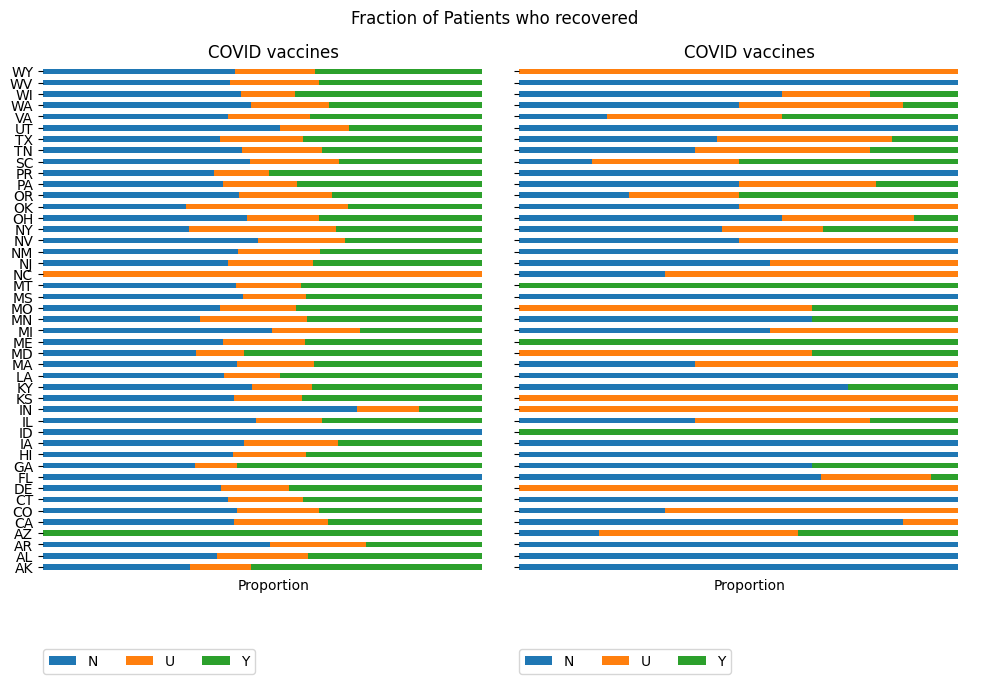

In [17]:
sel = dff.VAX_TYPE == 'COVID19'

fig, ax = plt.subplots(1,2, figsize = (10,7), sharey = True)
hax = ax[0]
tabProp = pd.crosstab(index = dff[sel]['STATE'], columns = dff[sel]['RECOVD'], normalize = "index")
tabProp.plot(kind='barh', stacked=True, ax = hax)
hax.legend(loc=(0, -0.2), ncol=3)
hax.set(frame_on=False, xticks=[], xlabel = 'Proportion', ylabel = None,
        title = 'COVID vaccines')

hax = ax[1]
tabProp = pd.crosstab(index = dff[~sel]['STATE'], columns = dff[~sel]['RECOVD'], normalize = "index")
tabProp.plot(kind='barh', stacked=True, ax = hax)
hax.legend(loc=(0, -0.2), ncol=3)
hax.set(frame_on=False, xticks=[], xlabel = 'Proportion', ylabel = None,
        title = 'COVID vaccines')
plt.suptitle('Fraction of Patients who recovered')
plt.tight_layout()

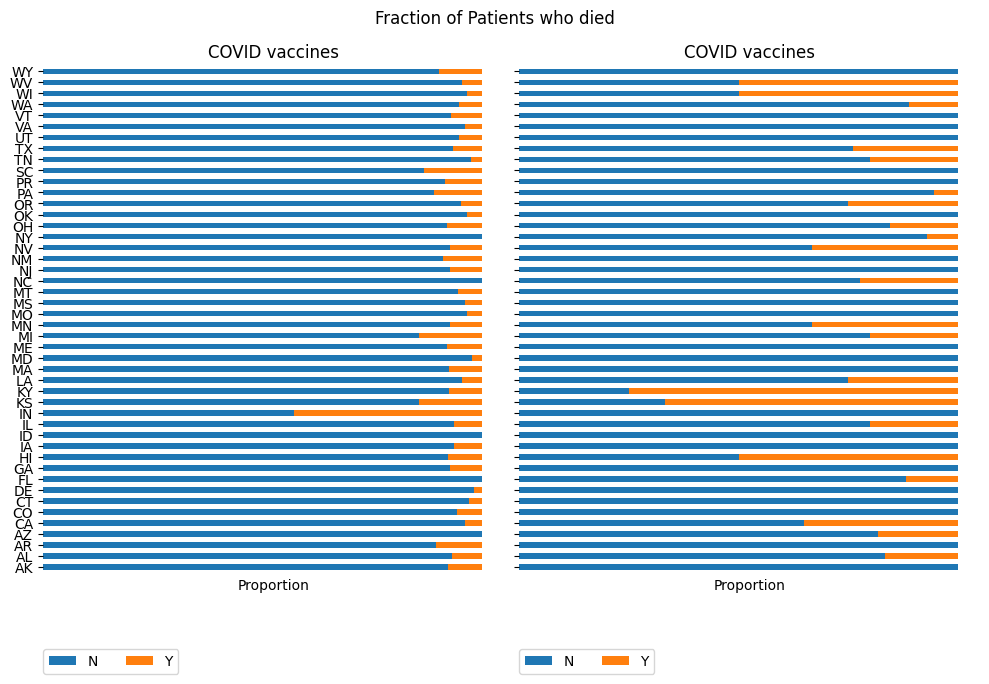

In [18]:
sel = dff.VAX_TYPE == 'COVID19'

dummy = dff.copy()
dummy.DIED[dummy.DIED != 'Y'] = 'N'
fig, ax = plt.subplots(1,2, figsize = (10,7), sharey = True)
hax = ax[0]
tabProp = pd.crosstab(index = dummy[sel]['STATE'], columns = dummy[sel]['DIED'], normalize = "index")
tabProp.plot(kind='barh', stacked=True, ax = hax)
hax.legend(loc=(0, -0.2), ncol=3)
hax.set(frame_on=False, xticks=[], xlabel = 'Proportion', ylabel = None,
        title = 'COVID vaccines')

hax = ax[1]
tabProp = pd.crosstab(index = dummy[~sel]['STATE'], columns = dummy[~sel]['DIED'], normalize = "index")
tabProp.plot(kind='barh', stacked=True, ax = hax)
hax.legend(loc=(0, -0.2), ncol=3)
hax.set(frame_on=False, xticks=[], xlabel = 'Proportion', ylabel = None,
        title = 'COVID vaccines')
plt.suptitle('Fraction of Patients who died')
plt.tight_layout()

## NLP Analysis

In [19]:
import nltk
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
import re  # Import the regular expressions module

# Download NLTK resources
nltk.download("punkt")
nltk.download("wordnet")
nltk.download('stopwords');
nltk.download('averaged_perceptron_tagger')

from nltk.corpus import stopwords;
stopwords = set(stopwords.words('english'))
stopwords.update(['of','the','to','be','that','with','on','for','by','at','one', 's', 't', 'n', 'nt', 'don', 'doesn']);

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [20]:
# Function to check if text is in first person
def is_first_person(text):
  if type(text) != str:
    output = False
  else:
    text = text.lower()
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)

    # Check if token indicates first person
    for word, pos in tagged:
        if word in ['i', 'me', 'my', 'mine', 'myself']: #not including plural first person
          output = True
        else:
          output = False
  return output

# Apply the function to the DataFrame
dff['FirstPerson'] = dff['SYMPTOM_TEXT'].apply(is_first_person)

In [21]:
y = [np.sum(dff['FirstPerson'] == True), np.sum(dff['FirstPerson'] == False)]
print(f'Among all the {np.sum(y)} reports, {y[0]} were detected to be written in first person')

Among all the 34121 reports, 3 were detected to be written in first person


In [22]:
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob

# Preprocess the text
def preprocess_text(text):
  # Initialize NLTK's Porter Stemmer
  stemmer = PorterStemmer()
  lemmatizer = WordNetLemmatizer()

  if type(text) != str:
    text = ''

  # Convert text to lowercase
  text = text.lower()

  # Tokenize the sentence
  text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
  text = re.sub(r'\d+', '', text)       # Remove numbers
  #textblb = TextBlob(text)
  #text = textblb.correct().string
  corrected_tokens = word_tokenize(text)

  # Remove stopwords
  corrected_tokens = [word for word in corrected_tokens if word not in stopwords]

  #Refine the list from None elements:
  corrected_tokens = [token for token in corrected_tokens if token is not None]
  #Normalize words
  #corrected_tokens = [stemmer.stem(word) for word in corrected_tokens]
  corrected_tokens = [lemmatizer.lemmatize(word) for word in corrected_tokens]

  output = ' '.join(corrected_tokens)
  return output


In [23]:
# Apply preprocessing to the DataFrame
dff['processed_text'] = np.repeat(np.nan, len(dff))
dff['processed_length'] = np.repeat(np.nan, len(dff))
for ix in range(len(dff)):
  if type(dff.SYMPTOM_TEXT[ix]) != str:
    continue
  dff['processed_text'][ix] = preprocess_text(dff.SYMPTOM_TEXT[ix])
  dff['processed_length'][ix] = len(dff.SYMPTOM_TEXT[ix])


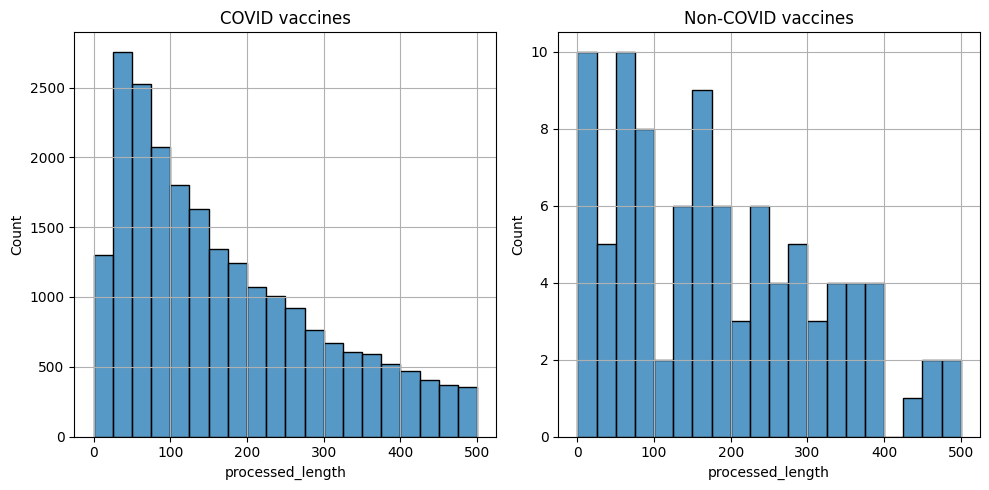

In [24]:
fig, ax = plt.subplots(1,2, figsize = (10,5), sharey = False)
binedges = [*range(0, 501, 25)]
sns.histplot(ax = ax[0], data = dff[dff.VAX_TYPE == 'COVID19'], x = 'processed_length', bins = binedges, cbar = True);
ax[0].set_title('COVID vaccines')
ax[0].grid()

sns.histplot(ax = ax[1], data = dff[dff.VAX_TYPE != 'COVID19'], x = 'processed_length', bins = binedges, cbar = True);
ax[1].set_title('Non-COVID vaccines')
ax[1].grid()
plt.tight_layout();

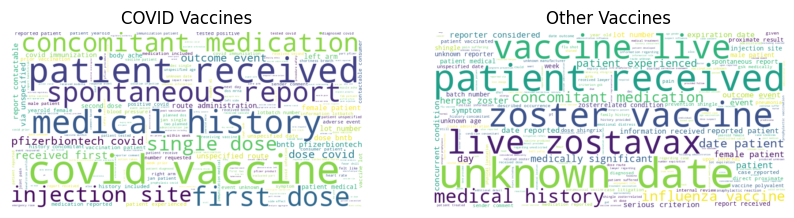

In [25]:
# Create a WordCloud instance
wc = WordCloud(width=800, height=400, background_color='white', stopwords = stopwords)

fig, ax = plt.subplots(1,2, figsize = (10,10), sharey = False)

var = 'VAX_TYPE'
dummy = dff.copy()
dummy.dropna(subset = 'processed_text', inplace = True)

# Create the WordCloud from the combined strings
combined_text = ' '.join(dummy['processed_text'][dummy[var] == 'COVID19'])
wc.generate(combined_text)

# Display the WordCloud
ax[0].imshow(wc, interpolation='bilinear')
ax[0].axis("off")
ax[0].set_title('COVID Vaccines')

# Create the WordCloud from the combined strings
combined_text = ' '.join(dummy['processed_text'][dummy[var] != 'COVID19'])
wc.generate(combined_text)

# Display the WordCloud
ax[1].imshow(wc, interpolation='bilinear')
ax[1].axis("off")
ax[1].set_title('Other Vaccines')

plt.show()


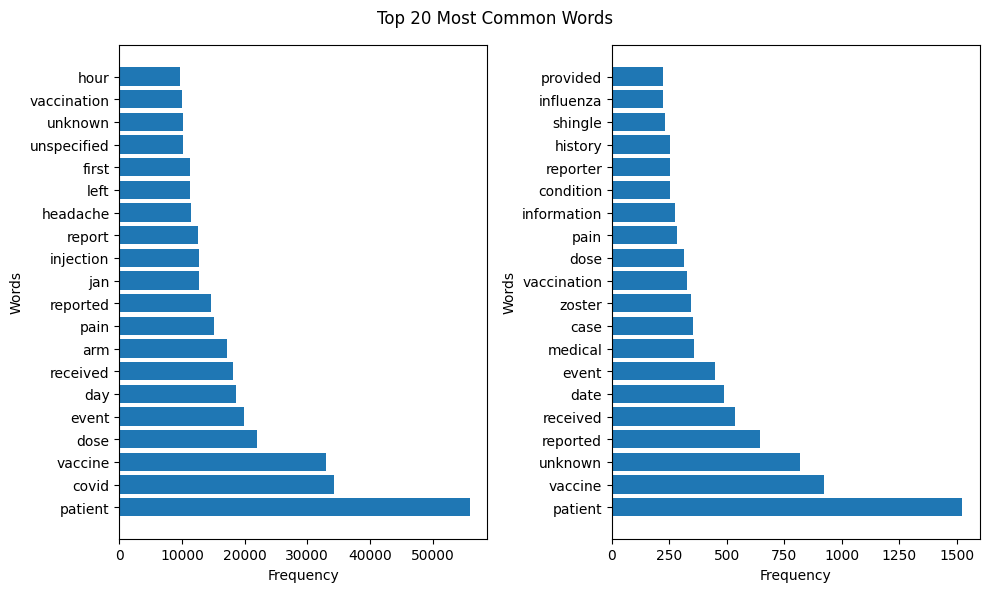

In [26]:
from collections import Counter

# Tokenize the text and remove stopwords
dummy = dff.copy()
dummy.dropna(subset = 'processed_text', inplace = True)
dummy.reset_index(drop = True, inplace = True)

# Select the top N most common words
top_n = 20

fig, ax = plt.subplots(1,2, figsize = (10, 6))
hax = ax[0]
sel = dummy.VAX_TYPE == 'COVID19'
combined_text = ' '.join(dummy['processed_text'][sel])
tokens = word_tokenize(combined_text)
filtered_tokens = [word for word in tokens if word.isalpha() and word not in stopwords]

# Count word frequencies
word_freq = Counter(filtered_tokens)
common_words = word_freq.most_common(top_n)
df_common_words = pd.DataFrame(common_words, columns=['Word', 'Frequency'])
hax.barh(y = df_common_words['Word'], width = df_common_words['Frequency'])
hax.set_ylabel('Words')
hax.set_xlabel('Frequency')

hax = ax[1]
sel = dummy.VAX_TYPE != 'COVID19'
combined_text = ' '.join(dummy['processed_text'][sel])
tokens = word_tokenize(combined_text)
filtered_tokens = [word for word in tokens if word.isalpha() and word not in stopwords]

# Count word frequencies
word_freq = Counter(filtered_tokens)
common_words = word_freq.most_common(top_n)
df_common_words = pd.DataFrame(common_words, columns=['Word', 'Frequency'])
hax.barh(y = df_common_words['Word'], width = df_common_words['Frequency'])
hax.set_ylabel('Words')
hax.set_xlabel('Frequency')

plt.suptitle(f'Top {top_n} Most Common Words')
plt.tight_layout()
plt.show()

In [27]:
#Remove words that are likely not symptoms:
additional = ['patient', 'covid', 'vaccine', 'dose', 'event', 'day', 'received', 'reported', 'injection', 'jan', 'hour', 'information', 'lot', 'week', 'spontaneous', 'report']
stopwords2 = stopwords
stopwords2.update(additional)


In [28]:
# Preprocess the text
def preprocess_text2(text):
  # Initialize NLTK's Porter Stemmer
  stemmer = PorterStemmer()
  lemmatizer = WordNetLemmatizer()

  if type(text) != str:
    text = ''

  # Convert text to lowercase
  text = text.lower()

  # Tokenize the sentence
  text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
  text = re.sub(r'\d+', '', text)       # Remove numbers
  #textblb = TextBlob(text)
  #text = textblb.correct().string
  corrected_tokens = word_tokenize(text)

  # Remove stopwords
  corrected_tokens = [word for word in corrected_tokens if word not in stopwords2]

  #Refine the list from None elements:
  corrected_tokens = [token for token in corrected_tokens if token is not None]
  #Normalize words
  #corrected_tokens = [stemmer.stem(word) for word in corrected_tokens]
  corrected_tokens = [lemmatizer.lemmatize(word) for word in corrected_tokens]

  output = ' '.join(corrected_tokens)
  return output


In [29]:
# Apply preprocessing to the DataFrame
dff2 = dff.copy()
dff2['processed_text'] = np.repeat(np.nan, len(dff2))
dff2['processed_length'] = np.repeat(np.nan, len(dff2))
for ix in range(len(dff2)):
  if type(dff2.SYMPTOM_TEXT[ix]) != str:
    continue
  dff2['processed_text'][ix] = preprocess_text(dff2.SYMPTOM_TEXT[ix])
  dff2['processed_length'][ix] = len(dff2.SYMPTOM_TEXT[ix])


In [30]:
def runPredictionAnalysis(X, y, model, n_runs = 20, k_folds = 5):
  #We run the model n_runs times (default = 20) with and k_fold (default = 5) cross validation:
  F1_N = [];
  F1_Y = [];
  Acc = [];
  for ix in range(n_runs):
    print(f'Run # {ix}');
    f1_N = [];
    f1_Y = [];
    acc = []
    #5-fold cross-validation:
    kf = KFold(n_splits=k_folds, shuffle=True)
    for k, (train_index, test_index) in enumerate(kf.split(X, y)):
        print(f'-- validation {k}')
        #training y test sets:
        x_train, x_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(x_train, y_train);

        y_pred = model.predict(x_test)
        y_prob = model.predict_proba(x_test)

        rep = classification_report(y_test, y_pred, output_dict = True);
        f1_N.append([rep['N']['f1-score'], ix]);
        f1_Y.append([rep['Y']['f1-score'], ix]);
        acc.append([rep['accuracy'], ix]);
    #print(f'Accuracy of the run #{ix} is {partial_mean(acc)}')
    F1_N.append([partial_mean(f1_N), ix]);
    F1_Y.append([partial_mean(f1_Y), ix]);
    Acc.append([partial_mean(acc), ix]);

  #return the collected accuracy and F1 for both classes, as well as the last train/test sets:
  print('Done!');
  return Acc, F1_N, F1_Y, model, x_train, x_test, y_train, y_test

def partial_mean(h):
  a=np.array(h);
  pm = a[:,0].mean();
  return pm

def plotPerformance(y_test, y_pred, F1_N, F1_Y, Acc):
  #Plotting:
  fig, ax = plt.subplots(1,2,figsize = (15,6));

  #Plot confusion matrix:
  mat = confusion_matrix(y_test, y_pred)
  sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True, cmap='inferno_r', ax = ax[0])
  ax[0].set_xlabel('True label')
  ax[0].set_ylabel('Predicted label');
  ax[0].set_title('Model Performance')

  #F1 report and Accuracy:
  dfF0 = pd.DataFrame(F1_N, columns = ['val', 'run']);
  dfF1 = pd.DataFrame(F1_Y, columns = ['val', 'run']);
  dfAcc = pd.DataFrame(Acc, columns = ['val', 'run']);

  sns.lineplot(data = dfF0, x = 'run', y = 'val', label = 'False', marker = 'o', markers=True, ax = ax[1])
  sns.lineplot(data = dfF1, x = 'run', y = 'val',  label = 'True', marker = 'o', markers=True, ax = ax[1])
  sns.lineplot(data = dfAcc, x = 'run', y = 'val', label = 'Accuracy', marker = 'o', markers=True, ax = ax[1])
  ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

  ax[1].set_xlabel('Run #');
  ax[1].set_title('Performance Curves')

  plt.show();

  print(f'Best accuracy: {np.max(dfAcc.val):.4f} at run# {np.argmax(dfAcc.val)}');
  print(f'Best F1 for Class False: {np.max(dfF0.val):.4f}')
  print(f'Best F1 for Class True: {np.max(dfF1.val):.4f}')

In [42]:
#We form and separate the predictors of the response:
dummy = dff2.copy()
dummy['bCOVID'] = np.repeat('Y', len(dff2));
dummy.bCOVID[dummy.VAX_TYPE != 'COVID19'] = 'N'
dummy.dropna(subset=['processed_text', 'bCOVID'], inplace = True)
dummy.reset_index(drop = True, inplace = True)
X = dummy['processed_text']
y = dummy['bCOVID'].astype('category')

n_runs = 10;
k_folds = 5;


Run # 0
-- validation 0
-- validation 1
-- validation 2
-- validation 3
-- validation 4
Run # 1
-- validation 0
-- validation 1
-- validation 2
-- validation 3
-- validation 4
Run # 2
-- validation 0
-- validation 1
-- validation 2
-- validation 3
-- validation 4
Run # 3
-- validation 0
-- validation 1
-- validation 2
-- validation 3
-- validation 4
Run # 4
-- validation 0
-- validation 1
-- validation 2
-- validation 3
-- validation 4
Run # 5
-- validation 0
-- validation 1
-- validation 2
-- validation 3
-- validation 4
Run # 6
-- validation 0
-- validation 1
-- validation 2
-- validation 3
-- validation 4
Run # 7
-- validation 0
-- validation 1
-- validation 2
-- validation 3
-- validation 4
Run # 8
-- validation 0
-- validation 1
-- validation 2
-- validation 3
-- validation 4
Run # 9
-- validation 0
-- validation 1
-- validation 2
-- validation 3
-- validation 4
Done!


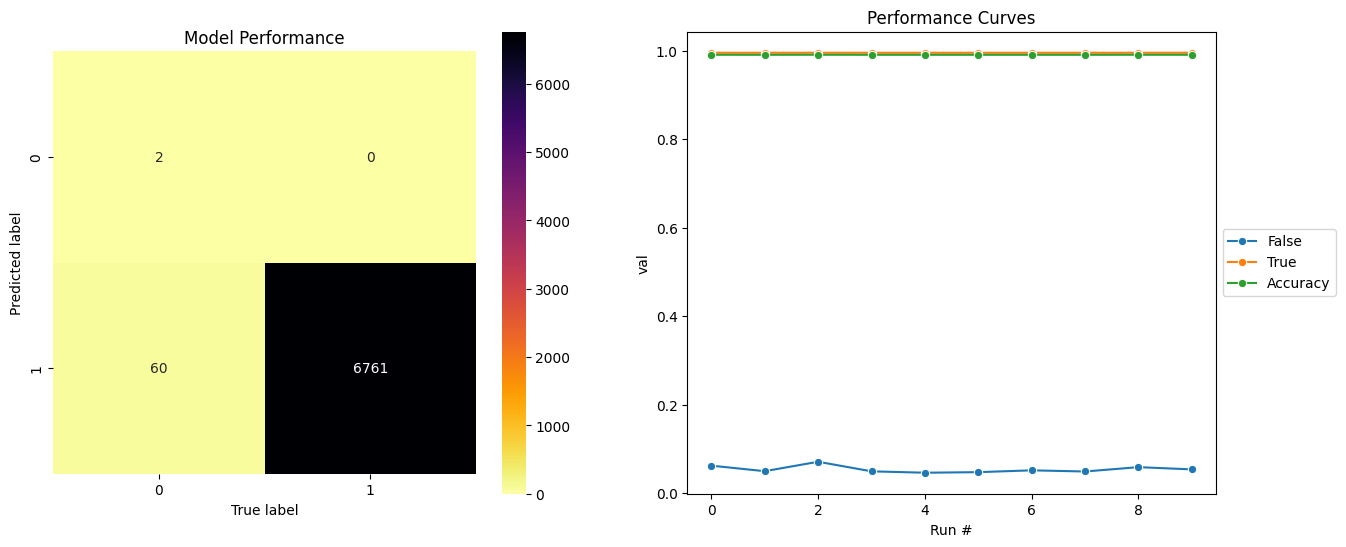

Best accuracy: 0.9908 at run# 2
Best F1 for Class False: 0.0713
Best F1 for Class True: 0.9954


In [43]:
#we generate the model together with the vectorizer using the stopwords filter:
model = make_pipeline(TfidfVectorizer(stop_words = list(stopwords2)), MultinomialNB())

#We train the model several times with cross-validation:
Acc, F1_0, F1_1, fit_model, x_train, x_test, y_train, y_test = runPredictionAnalysis(X, y, model, n_runs = n_runs, k_folds = k_folds);

#Accuracy and F1 report with the final model:
y_pred = fit_model.predict(x_test);
plotPerformance(y_test, y_pred, F1_0, F1_1, Acc);

In [38]:
from sklearn.utils import resample

# Determine the number of samples in the minority class
minority_class_size = np.sum(dff['VAX_TYPE'] != 'COVID19')

# Separate the majority
covid_vax = dff[dff['VAX_TYPE'] == 'COVID19'].reset_index(drop = True)
other_vax = dff[dff['VAX_TYPE'] != 'COVID19'].reset_index(drop = True)

# Undersample the majority class (COVID-related) to match the size of the minority class
modified = resample(other_vax, replace=True, n_samples=len(covid_vax), random_state=42)

# Combine the undersampled majority class and the original minority class
resampled = pd.concat([modified, covid_vax])

# Optionally reset the index
resampled.reset_index(drop=True, inplace = True)

Run # 0
-- validation 0
-- validation 1
-- validation 2
-- validation 3
-- validation 4
Run # 1
-- validation 0
-- validation 1
-- validation 2
-- validation 3
-- validation 4
Run # 2
-- validation 0
-- validation 1
-- validation 2
-- validation 3
-- validation 4
Run # 3
-- validation 0
-- validation 1
-- validation 2
-- validation 3
-- validation 4
Run # 4
-- validation 0
-- validation 1
-- validation 2
-- validation 3
-- validation 4
Run # 5
-- validation 0
-- validation 1
-- validation 2
-- validation 3
-- validation 4
Run # 6
-- validation 0
-- validation 1
-- validation 2
-- validation 3
-- validation 4
Run # 7
-- validation 0
-- validation 1
-- validation 2
-- validation 3
-- validation 4
Run # 8
-- validation 0
-- validation 1
-- validation 2
-- validation 3
-- validation 4
Run # 9
-- validation 0
-- validation 1
-- validation 2
-- validation 3
-- validation 4
Done!


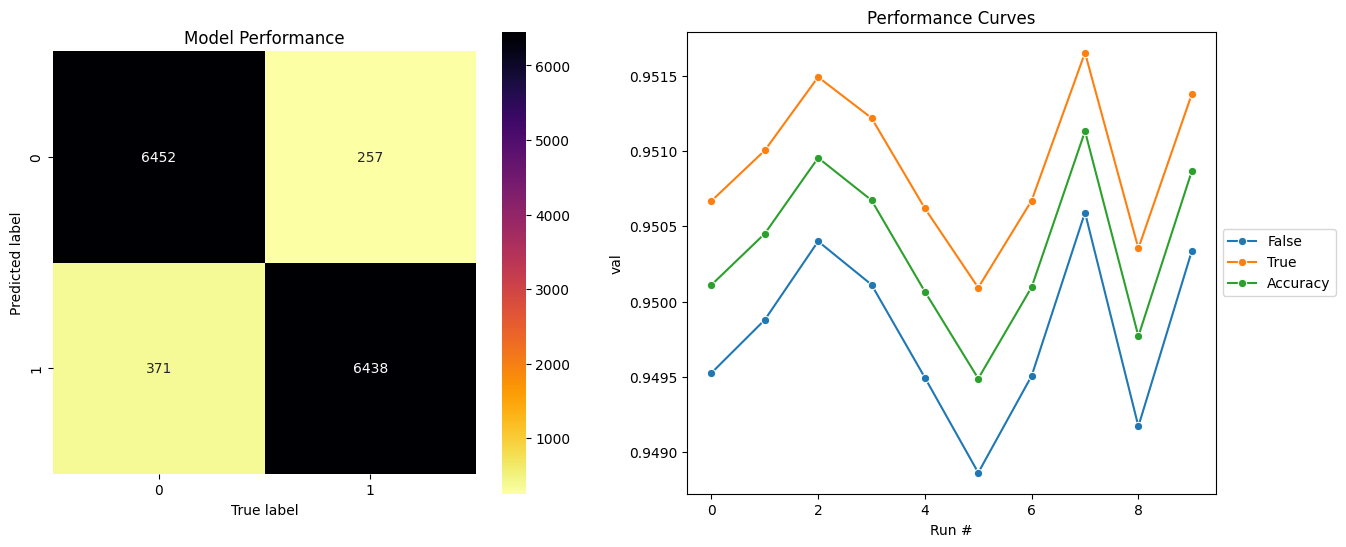

Best accuracy: 0.9511 at run# 7
Best F1 for Class False: 0.9506
Best F1 for Class True: 0.9517


In [40]:
dummy = resampled.copy()
dummy['bCOVID'] = np.repeat('Y', len(dummy))
dummy.loc[dummy['VAX_TYPE'] != 'COVID19', 'bCOVID'] = 'N'

# Drop rows with missing data
dummy.dropna(subset=['processed_text', 'bCOVID'], inplace=True)
dummy.reset_index(drop=True, inplace=True)

# Separate features and target variable
X = dummy['processed_text']
y = dummy['bCOVID'].astype('category')

#we generate the model together with the vectorizer using the stopwords filter:
model = make_pipeline(TfidfVectorizer(stop_words = list(stopwords2)), MultinomialNB())

#We train the model several times with cross-validation:
Acc, F1_0, F1_1, fit_model, x_train, x_test, y_train, y_test = runPredictionAnalysis(X, y, model, n_runs = n_runs, k_folds = k_folds);

#Accuracy and F1 report with the final model:
y_pred = fit_model.predict(x_test);
plotPerformance(y_test, y_pred, F1_0, F1_1, Acc);

In [ ]:
# Split the data into training and testing sets
dummy = undersampled_df.copy()
dummy['bCOVID'] = np.repeat('Y', len(dff2));
dummy.bCOVID[dummy.VAX_TYPE != 'COVID19'] = 'N'
dummy.dropna(subset=['processed_text', 'bCOVID'], inplace = True)
dummy.reset_index(drop = True, inplace = True)
X = dummy['processed_text']
y = dummy['bCOVID'].astype('category')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convert text data to TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features as needed
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

classifier = LogisticRegression()
classifier.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test_tfidf)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))